In [56]:
!pip install datasets pandas torch openpyxl banglanltk bangla-stemmer gensim pyLDAvis

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from tqdm import tqdm
import time
from bangla_stemmer.stemmer import stemmer
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,log_loss,jaccard_score,roc_auc_score,classification_report,confusion_matrix
from torch.utils.data import Dataset, DataLoader

# **Train Dataset Loading**

In [58]:
# Read the xlxs file into a DataFrame

train_data  = pd.read_excel("/kaggle/input/revolution-24/AUG_Revolt_24 - Sheet1.xlsx")
stopwords_df = pd.read_excel('/kaggle/input/stopwords/stopwords_bangla.xlsx')
# Display the DataFrame
train_data.head()

,date,Headline,Sentiment
0,2024-07-05,ঢাকা বিশ্ববিদ্যালয়: কোটাবিরোধী আন্দোলনের নেতাক...,outrage
1,2024-07-05,কোটাবিরোধী আন্দোলনে ঢাকা বিশ্ববিদ্যালয়ের বিএনপ...,hope
2,2024-07-05,কোটাবিরোধী আন্দোলন : আজও জিরো পয়েন্ট অবরোধ করে...,outrage
3,2024-07-06,"সর্বজনীন পেনশন: সরকার অনড়, আন্দোলন চালিয়ে যাবে...",outrage
4,2024-07-06,আজ শনিবার সকাল সাড়ে ১০টার দিকে মহাসড়কের শহর বা...,outrage


In [59]:
stopwords_df.head()

,Unnamed: 0,words
0,0,অই
1,1,অগত্যা
2,2,অত: পর
3,3,অতএব
4,4,অথচ


In [60]:
# drop date
train_data = train_data.drop('date', axis=1)

In [61]:
import re

def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\u2600-\u26FF"          # miscellaneous symbols
                               u"\u2700-\u27BF"          # dingbats
                               u"\u2000-\u206F"          # general punctuations
                               "]+", flags=re.UNICODE)
    english_pattern = re.compile('[a-zA-Z]+', flags=re.I)

    text = emoji_pattern.sub(r'', text)
    text = english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct += char

    return no_punct

def preprocessing(text):
    text = replace_strings(text)
    text = remove_punctuations(text)
    return text

In [62]:
# prompt: for each Headline column of posts_df, apply the preprocessing function to each row

train_data['Headline'] =train_data['Headline'].apply(lambda x: preprocessing(str(x)))
train_data.head()

,Headline,Sentiment
0,ঢাকা বিশ্ববিদ্যালয় কোটাবিরোধী আন্দোলনের নেতাকে...,outrage
1,কোটাবিরোধী আন্দোলনে ঢাকা বিশ্ববিদ্যালয়ের বিএনপ...,hope
2,কোটাবিরোধী আন্দোলন আজও জিরো পয়েন্ট অবরোধ করে ...,outrage
3,সর্বজনীন পেনশন সরকার অনড় আন্দোলন চালিয়ে যাবেন ...,outrage
4,আজ শনিবার সকাল সাড়ে টার দিকে মহাসড়কের শহর বাইপ...,outrage


In [63]:
# Remove Stopwords
def stopwordRemoval(text):
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stopwords_df]

    out=' '.join(stm)

    return str(out)

In [64]:
train_data['Headline'] =train_data['Headline'].apply(lambda x: stopwordRemoval(str(x)))
train_data.head()

,Headline,Sentiment
0,ঢাকা বিশ্ববিদ্যালয় কোটাবিরোধী আন্দোলনের নেতাকে...,outrage
1,কোটাবিরোধী আন্দোলনে ঢাকা বিশ্ববিদ্যালয়ের বিএনপ...,hope
2,কোটাবিরোধী আন্দোলন আজও জিরো পয়েন্ট অবরোধ করে খ...,outrage
3,সর্বজনীন পেনশন সরকার অনড় আন্দোলন চালিয়ে যাবেন ...,outrage
4,আজ শনিবার সকাল সাড়ে টার দিকে মহাসড়কের শহর বাইপ...,outrage


In [65]:
# stemmer function
def stem_text(x):
  stmr = stemmer.BanglaStemmer()
  words=x.split(' ')
  stm = stmr.stem(words)
  words=(' ').join(stm)
  return words

In [66]:
train_data['Headline'] =train_data['Headline'].apply(lambda x: stem_text(str(x)))

applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..


In [67]:
#make test_data and val data_from train_data
train_data, val_data = train_test_split(train_data, test_size=0.3, random_state=42,stratify=train_data['Sentiment'])
# make test data from val data
val_data, test_data = train_test_split(val_data, test_size=0.5, random_state=42,stratify=val_data['Sentiment'])

In [68]:
len(train_data)

1759

In [69]:
len(test_data)

378

In [70]:
len(val_data)

377

In [71]:
label_counts = train_data['Sentiment'].value_counts()
label_counts

Sentiment
despair    587
hope       586
outrage    586
Name: count, dtype: int64

# **Visualization of Label Distribution in Train Dataset**
  

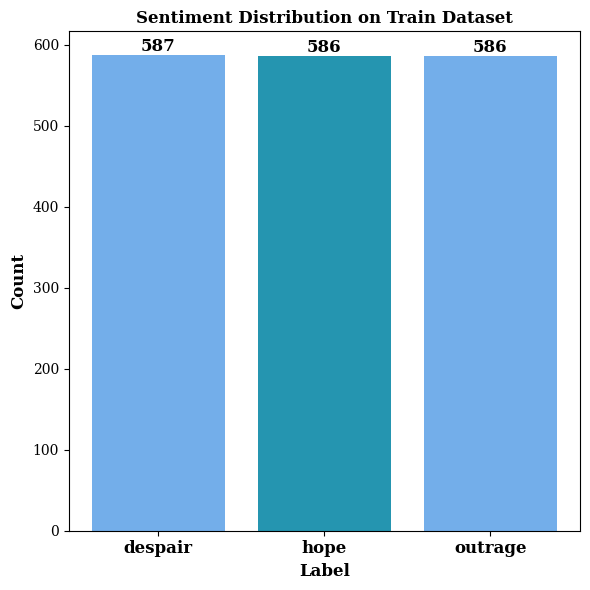

In [72]:
label_counts = train_data['Sentiment'].value_counts()

# Define custom colors for the bars
custom_colors = ['#73aeea', '#2595b0']

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

plt.figure(figsize=(6, 6))

# Create bar plot with grid
bars = plt.bar(label_counts.index, label_counts.values, color=custom_colors)


# Set title and axis labels using custom fontdict
plt.title('Sentiment Distribution on Train Dataset', fontdict=font)
plt.xlabel('Label', fontdict=font)
plt.ylabel('Count', fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(label_counts.index, label_counts.index, fontdict=font)
plt.yticks(fontname='Serif', fontsize=10)

# Adding annotations (count values) on top of each bar
for bar, count in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontdict=font)

# Show the plot
# Adjust layout to prevent cropping
plt.tight_layout()
plt.savefig('Rev_train.pdf')  # Save as pdf format
plt.show()


# **Visualization of Label Distribution in Test Dataset**


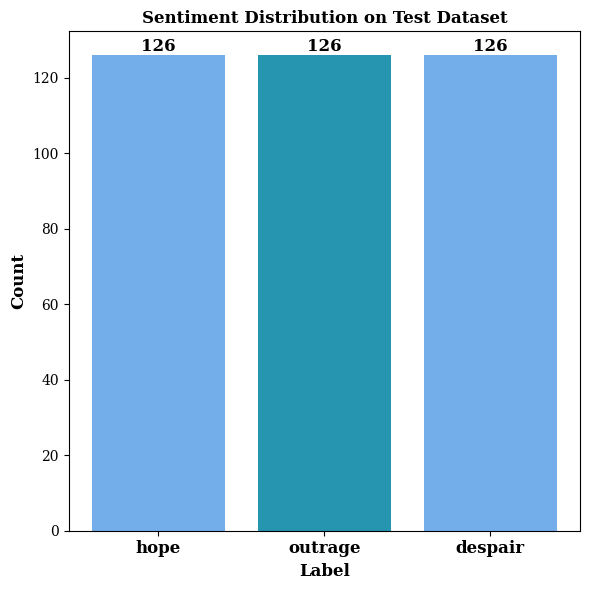

In [73]:
label_counts = test_data['Sentiment'].value_counts()

# Define custom colors for the bars
custom_colors = ['#73aeea', '#2595b0']

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

plt.figure(figsize=(6, 6))

# Create bar plot with grid
bars = plt.bar(label_counts.index, label_counts.values, color=custom_colors)


# Set title and axis labels using custom fontdict
plt.title('Sentiment Distribution on Test Dataset', fontdict=font)
plt.xlabel('Label', fontdict=font)
plt.ylabel('Count', fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(label_counts.index, label_counts.index, fontdict=font)
plt.yticks(fontname='Serif', fontsize=10)

# Adding annotations (count values) on top of each bar
for bar, count in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontdict=font)

# Show the plot
# Adjust layout to prevent cropping
plt.tight_layout()
plt.savefig('test.pdf')  # Save as pdf format
plt.show()


# **Visualization of Label Distribution in Validation Dataset**


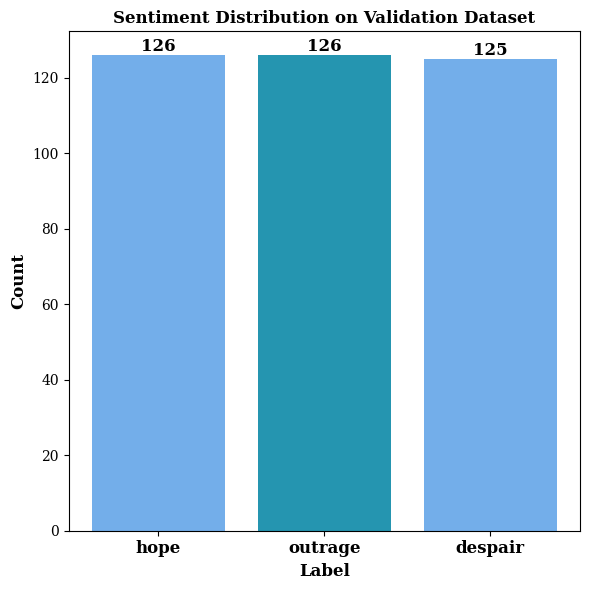

In [74]:
label_counts = val_data['Sentiment'].value_counts()

# Define custom colors for the bars
custom_colors = ['#73aeea', '#2595b0']

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

plt.figure(figsize=(6, 6))

# Create bar plot with grid
bars = plt.bar(label_counts.index, label_counts.values, color=custom_colors)


# Set title and axis labels using custom fontdict
plt.title('Sentiment Distribution on Validation Dataset', fontdict=font)
plt.xlabel('Label', fontdict=font)
plt.ylabel('Count', fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(label_counts.index, label_counts.index, fontdict=font)
plt.yticks(fontname='Serif', fontsize=10)

# Adding annotations (count values) on top of each bar
for bar, count in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontdict=font)

# Show the plot
# Adjust layout to prevent cropping
plt.tight_layout()
plt.savefig('validation.pdf')  # Save as pdf format
plt.show()


In [75]:
print(f"Length of train dataset: {len(train_data)}")
print(f"Length of test dataset: {len(test_data)}")
print(f"Length of validation dataset: {len(val_data)}")

Length of train dataset: 1759
Length of test dataset: 378
Length of validation dataset: 377


# **Custom Dataset Class**

In [76]:
class BanglaPoliticalSentimentDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Define a mapping for sentiment labels
        self.sentiment_map = {"outrage": 0, "hope": 1,"despair":2}  # You can add more sentiments if needed

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        content = self.data.iloc[idx]['Headline']
        label = self.data.iloc[idx]['Sentiment']

        # Convert sentiment label to integer using the mapping
        label = self.sentiment_map[label]

        inputs = self.tokenizer.encode_plus(
            content,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long) #torch.nn.CrossEntropyLoss expects the target labels to be torch.LongTensor.
        }


In [77]:
!pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-q3nyba0f
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-q3nyba0f
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done


In [78]:
!pip install transformers[sentencepiece]

In [79]:
!pip install torch

In [80]:
!pip install accelerate -U

# **BanglaBERT model and its tokenizer**

In [81]:
# Model loading
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW
from normalizer import normalize # pip install git+https://github.com/csebuetnlp/normalizer
num_classes = 3  #number of classes in our dataset

model_name = "csebuetnlp/banglabert"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [82]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

# **Apply normalization to the datasets**

In [83]:
# Apply normalization to the datasets
train_data['Headline'] = train_data['Headline'].apply(normalize)
test_data['Headline'] = test_data['Headline'].apply(normalize)
val_data['Headline'] = val_data['Headline'].apply(normalize)

# **Custom dataset and dataloader**

In [84]:
# Define custom datasets
train_dataset = BanglaPoliticalSentimentDataset(train_data, tokenizer)
val_dataset = BanglaPoliticalSentimentDataset(val_data, tokenizer)
test_dataset = BanglaPoliticalSentimentDataset(test_data, tokenizer)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=6, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=False)

# **Train Dataset Encoding Printing**

In [85]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in train_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


#     # Break out of the loop after processing the first batch
    break


Input IDs: tensor([    2, 24120, 31250,  5049,  3898,  3131,   792, 15211,  6356,  1074,
         3758,  3028,  3142,  3910,  2509,   844,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,    

# **Test Dataset Encoding Printing**

In [86]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in test_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Print information
#     print("Input IDs:", input_ids)
#     print("Attention Mask:", attention_mask)
#     print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


# **Validation Dataset Encoding Printing**

In [87]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in val_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Print information
#     print("Input IDs:", input_ids)
#     print("Attention Mask:", attention_mask)
#     print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


# **Train Dataset Decoding Printing**

In [88]:
# Set a flag to track whether it's the first batch
first_batch = True

# Iterate through the DataLoader
for batch in train_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]

    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    #print("Decoded Input Text:", decoded_input_text)
    #print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = labels.item()  # Assuming labels are single integers
    #print("Label:", decoded_labels)

    # Break out of the loop after processing the first sample from the first batch
    break


# **Test Dataset Decoding Printing**

In [89]:
# Set a flag to track whether it's the first batch
first_batch = True

# Iterate through the DataLoader
for batch in test_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]

    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    #print("Decoded Input Text:", decoded_input_text)
    #print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = labels.item()  # Assuming labels are single integers
    #print("Label:", decoded_labels)

    # Break out of the loop after processing the first sample from the first batch
    break


# **Validation Dataset Decoding Printing**

In [90]:
# Set a flag to track whether it's the first batch
first_batch = True

# Iterate through the DataLoader
for batch in val_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]

    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    #print("Decoded Input Text:", decoded_input_text)
    #print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = labels.item()  # Assuming labels are single integers
    #print("Label:", decoded_labels)

    # Break out of the loop after processing the first sample from the first batch
    break


In [91]:
torch.cuda.empty_cache()

# **Optimizer and Loss Function**

In [92]:
import torch.optim as optim
learning_rate = 2e-5
# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# **Training the model**

In [93]:
import time
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Training loop parameters
num_epochs = 100
gradient_accumulation_steps = 16  # Accumulate gradients over 16 steps
patience = 10  # Number of epochs to wait for improvement before stopping
best_val_accuracy = 0
patience_counter = 0
# Initialize lists to store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Start time of the epoch
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    optimizer.zero_grad()

    # Wrap train_loader with tqdm for progress bar
    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Logits directly from the model output

        loss = criterion(logits, labels)
        total_loss += loss.item()

        # Compute training accuracy
        _, predicted = torch.max(logits, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        loss = loss / gradient_accumulation_steps
        loss.backward()

        if (batch_idx + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    print(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Train Accuracy: {train_accuracy:.4f}')

    # Validation
    model.eval()
    val_preds = []
    val_labels = []
    val_loss = 0

    # Wrap val_loader with tqdm for progress bar
    for batch in tqdm(val_loader, desc=f'Validation', leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # Logits directly from the model output

            loss = criterion(logits, labels)
            val_loss += loss.item()

        _, predicted = torch.max(logits, 1)

        val_preds.extend(predicted.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)
    print(f'Epoch {epoch + 1}/{num_epochs} - Val Loss: {avg_val_loss:.4f} - Val Accuracy: {val_accuracy:.4f}')

    # Early stopping check
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        patience_counter = 0  # Reset patience counter
        print("Validation accuracy improved. Saving model...")
        torch.save(model.state_dict(), "best_model.pth")  # Save the model
    else:
        patience_counter += 1
        print(f"No improvement in validation accuracy. Patience counter: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print("Early stopping triggered. Training terminated.")
        break
    # At the end of each epoch, store metrics for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Calculate and print epoch training time
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1} completed in {epoch_time // 60:.0f}m {epoch_time % 60:.0f}s")


Epoch 1/100 - Train Loss: 1.0680 - Train Accuracy: 0.4741


Epoch 1/100 - Val Loss: 1.0153 - Val Accuracy: 0.5623
Validation accuracy improved. Saving model...
Epoch 1 completed in 1m 42s


Epoch 2/100 - Train Loss: 0.8989 - Train Accuracy: 0.7049


Epoch 2/100 - Val Loss: 0.7857 - Val Accuracy: 0.7162
Validation accuracy improved. Saving model...
Epoch 2 completed in 1m 42s


Epoch 3/100 - Train Loss: 0.6324 - Train Accuracy: 0.8022


Epoch 3/100 - Val Loss: 0.6237 - Val Accuracy: 0.7692
Validation accuracy improved. Saving model...
Epoch 3 completed in 1m 42s


Epoch 4/100 - Train Loss: 0.3894 - Train Accuracy: 0.8903


Epoch 4/100 - Val Loss: 0.5595 - Val Accuracy: 0.8143
Validation accuracy improved. Saving model...
Epoch 4 completed in 1m 42s


Epoch 5/100 - Train Loss: 0.2430 - Train Accuracy: 0.9403


Epoch 5/100 - Val Loss: 0.5329 - Val Accuracy: 0.8064
No improvement in validation accuracy. Patience counter: 1/10
Epoch 5 completed in 1m 41s


Epoch 6/100 - Train Loss: 0.1413 - Train Accuracy: 0.9710


Epoch 6/100 - Val Loss: 0.5432 - Val Accuracy: 0.8382
Validation accuracy improved. Saving model...
Epoch 6 completed in 1m 42s


Epoch 7/100 - Train Loss: 0.0863 - Train Accuracy: 0.9829


Epoch 7/100 - Val Loss: 0.6276 - Val Accuracy: 0.8223
No improvement in validation accuracy. Patience counter: 1/10
Epoch 7 completed in 1m 41s


Epoch 8/100 - Train Loss: 0.0657 - Train Accuracy: 0.9869


Epoch 8/100 - Val Loss: 0.6531 - Val Accuracy: 0.8223
No improvement in validation accuracy. Patience counter: 2/10
Epoch 8 completed in 1m 41s


Epoch 9/100 - Train Loss: 0.0379 - Train Accuracy: 0.9949


Epoch 9/100 - Val Loss: 0.6096 - Val Accuracy: 0.8329
No improvement in validation accuracy. Patience counter: 3/10
Epoch 9 completed in 1m 41s


Epoch 10/100 - Train Loss: 0.0314 - Train Accuracy: 0.9949


Epoch 10/100 - Val Loss: 0.6765 - Val Accuracy: 0.8302
No improvement in validation accuracy. Patience counter: 4/10
Epoch 10 completed in 1m 41s


Epoch 11/100 - Train Loss: 0.0257 - Train Accuracy: 0.9955


Epoch 11/100 - Val Loss: 0.7132 - Val Accuracy: 0.8329
No improvement in validation accuracy. Patience counter: 5/10
Epoch 11 completed in 1m 41s


Epoch 12/100 - Train Loss: 0.0165 - Train Accuracy: 0.9977


Epoch 12/100 - Val Loss: 0.7286 - Val Accuracy: 0.8408
Validation accuracy improved. Saving model...
Epoch 12 completed in 1m 42s


Epoch 13/100 - Train Loss: 0.0151 - Train Accuracy: 0.9983


Epoch 13/100 - Val Loss: 0.8216 - Val Accuracy: 0.8276
No improvement in validation accuracy. Patience counter: 1/10
Epoch 13 completed in 1m 41s


Epoch 14/100 - Train Loss: 0.0133 - Train Accuracy: 0.9983


Epoch 14/100 - Val Loss: 0.8346 - Val Accuracy: 0.8276
No improvement in validation accuracy. Patience counter: 2/10
Epoch 14 completed in 1m 41s


Epoch 15/100 - Train Loss: 0.0167 - Train Accuracy: 0.9972


Epoch 15/100 - Val Loss: 0.8312 - Val Accuracy: 0.8117
No improvement in validation accuracy. Patience counter: 3/10
Epoch 15 completed in 1m 41s


Epoch 16/100 - Train Loss: 0.0528 - Train Accuracy: 0.9835


Epoch 16/100 - Val Loss: 0.8841 - Val Accuracy: 0.8090
No improvement in validation accuracy. Patience counter: 4/10
Epoch 16 completed in 1m 41s


Epoch 17/100 - Train Loss: 0.0666 - Train Accuracy: 0.9835


Epoch 17/100 - Val Loss: 0.7151 - Val Accuracy: 0.8276
No improvement in validation accuracy. Patience counter: 5/10
Epoch 17 completed in 1m 41s


Epoch 18/100 - Train Loss: 0.0295 - Train Accuracy: 0.9915


Epoch 18/100 - Val Loss: 0.7365 - Val Accuracy: 0.8064
No improvement in validation accuracy. Patience counter: 6/10
Epoch 18 completed in 1m 41s


Epoch 19/100 - Train Loss: 0.0174 - Train Accuracy: 0.9966


Epoch 19/100 - Val Loss: 0.9213 - Val Accuracy: 0.7878
No improvement in validation accuracy. Patience counter: 7/10
Epoch 19 completed in 1m 41s


Epoch 20/100 - Train Loss: 0.0126 - Train Accuracy: 0.9977


Epoch 20/100 - Val Loss: 0.9670 - Val Accuracy: 0.7984
No improvement in validation accuracy. Patience counter: 8/10
Epoch 20 completed in 1m 41s


Epoch 21/100 - Train Loss: 0.0083 - Train Accuracy: 0.9989


Epoch 21/100 - Val Loss: 0.8213 - Val Accuracy: 0.8329
No improvement in validation accuracy. Patience counter: 9/10
Epoch 21 completed in 1m 41s


Epoch 22/100 - Train Loss: 0.0060 - Train Accuracy: 0.9994


Epoch 22/100 - Val Loss: 0.8237 - Val Accuracy: 0.8329
No improvement in validation accuracy. Patience counter: 10/10
Early stopping triggered. Training terminated.


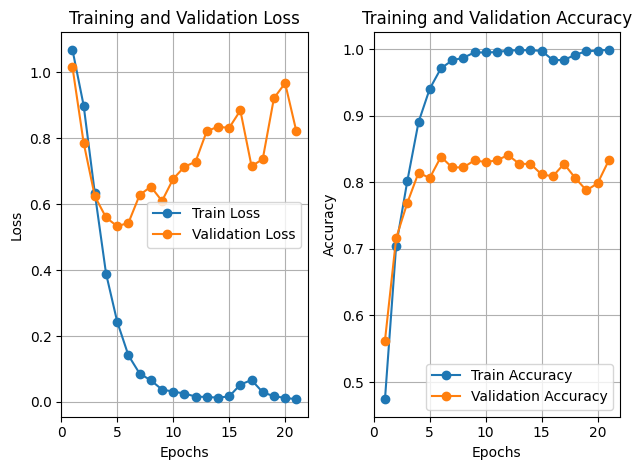

In [94]:
# Plot Training Loss vs Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()

# Plot Training Accuracy vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.savefig('training_validation_metrics.png')  # Optional: Save the plots as a PDF
plt.show()

# **Testing the model**

In [95]:
test_preds = []
test_labels = []
test_probs = []  # Store predicted probabilities

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Assuming our model directly outputs logits
        probabilities = torch.softmax(outputs.logits, dim=1)  # Softmax to get probabilities
        _, predicted = torch.max(outputs.logits, 1)

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probabilities.cpu().numpy())  # Append predicted probabilities

test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='macro')
test_recall = recall_score(test_labels, test_preds, average='macro')
test_f1 = f1_score(test_labels, test_preds, average='macro')

Testing: 100%|██████████| 63/63 [00:07<00:00,  8.90it/s]


In [96]:
from sklearn.metrics import classification_report

# Assuming `test_labels` and `test_preds` contain the true labels and model predictions
# Convert them to numpy arrays if they are not already
test_labels = np.array(test_labels)  # Replace `test_labels` with your variable name if different
test_preds = np.array(test_preds)    # Replace `test_preds` with your variable name if different
# Generate classification report
class_names = ['outrage', 'hope', 'despair']
report = classification_report(test_labels, test_preds, target_names=class_names)

# Print the classification report
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     outrage       0.89      0.82      0.85       126
        hope       0.78      0.91      0.84       126
     despair       0.87      0.79      0.82       126

    accuracy                           0.84       378
   macro avg       0.84      0.84      0.84       378
weighted avg       0.84      0.84      0.84       378



# **Printing the evaluation metric results**

In [97]:
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test F1 Score: {test_f1}')

Test Accuracy: 0.8386243386243386
Test Precision: 0.8444597047137883
Test Recall: 0.8386243386243386
Test F1 Score: 0.8385519092718828


# **Confusion Matrix of Political_Sentiment_Analysis**

<ipython-input-101-118f78b93202>:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="Blues"))


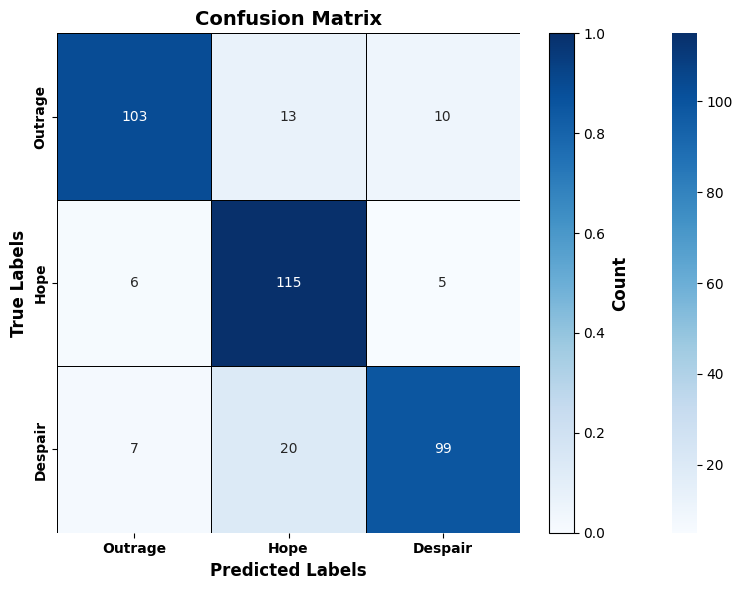

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace with your actual confusion matrix values
conf_matrix = confusion_matrix(test_labels, test_preds)

# Class names (adjust based on your dataset)
class_names = ['Outrage', 'Hope', 'Despair']

# Plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))

# Define colormap and plot heatmap
sns.heatmap(
    conf_matrix,
    annot=True,             # Show cell values
    fmt='d',                # Format as integers
    cmap="Blues",           # Use the "Blues" colormap
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=0.5,         # Add gridlines for clarity
    linecolor='black'       # Color of the gridlines
)

# Add labels and title
plt.xlabel('Predicted Labels', fontsize=12, fontweight='bold')
plt.ylabel('True Labels', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')

# Add a color bar with a label
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="Blues"))
cbar.set_label('Count', fontsize=12, fontweight='bold')

# Customize ticks on both axes for better readability
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the heatmap as a PDF or other file format
plt.savefig('confusion_matrix_classification.png')

# Display the plot
plt.show()
